<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: France Martínez</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [184]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


Se carga la señal de strain proveniente del detector LIGO. Esta señal contiene información sobre posibles eventos de ondas gravitacionales, mezclados con ruido instrumental.


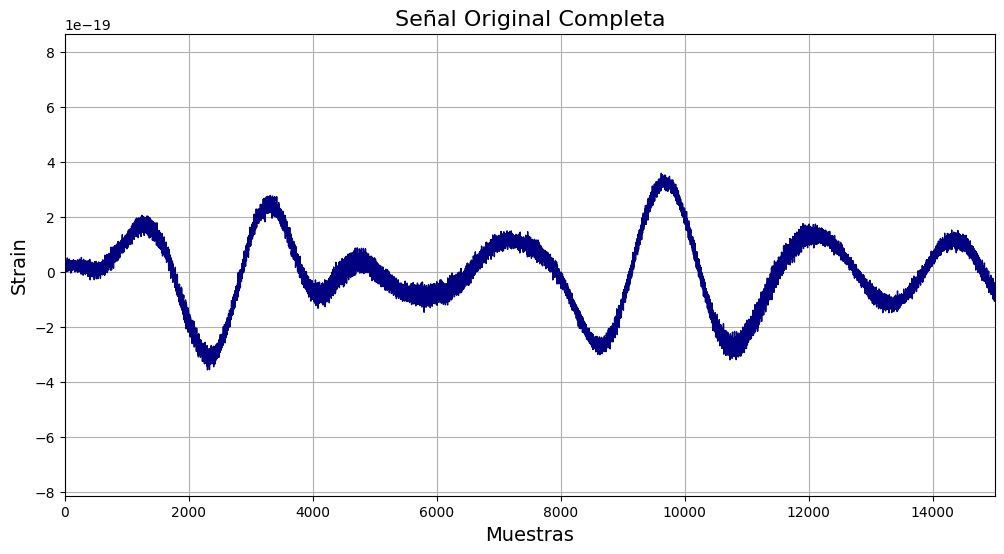

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, sosfilt, spectrogram, resample
from scipy.signal.windows import tukey
from IPython.display import Audio

# Parámetros
fs = 16000  # Frecuencia de muestreo (Hz)
ruta_archivo = "H1.txt"

# Carga de datos
senal_original = np.loadtxt(ruta_archivo, delimiter=",", skiprows=1)

# Visualización de la señal completa
plt.figure(figsize=(12, 6))
plt.plot(senal_original, color='navy', linewidth=1)
plt.title('Señal Original Completa', fontsize=16)
plt.xlabel('Muestras', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(True)
plt.xlim(0, 15000)
plt.show()

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

Convertimos la señal a formato de audio para escuchar el nivel de ruido. Las ondas gravitacionales (tipo chirp) son audibles en esta escala.

In [186]:
Audio(senal_original, rate=fs)

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


Se analiza la señal en el dominio de la frecuencia para detectar patrones de ruido característicos del instrumento, como picos o estructuras tipo peine.

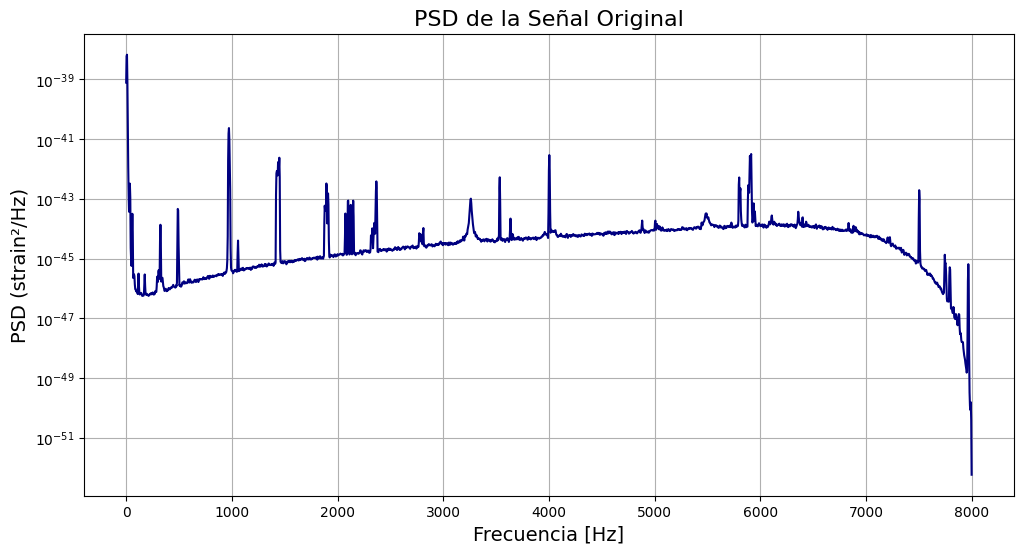

In [3]:
frecuencias, psd_original = welch(senal_original, fs=fs, nperseg=4096)

plt.figure(figsize=(12, 6))
plt.semilogy(frecuencias, psd_original, color='navy')
plt.title('PSD de la Señal Original', fontsize=16)
plt.xlabel('Frecuencia [Hz]', fontsize=14)
plt.ylabel('PSD (strain²/Hz)', fontsize=14)
plt.grid(True)
plt.show()

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


Se aplica procesamiento para limpiar la señal: windowing, blanqueamiento (whitening) y filtrado pasa banda.

## 4.1 Aplicación de Ventana Tukey
Aplicamos una ventana Tukey para reducir el efecto de las discontinuidades en los bordes de la señal, que pueden causar artefactos en el análisis espectral.

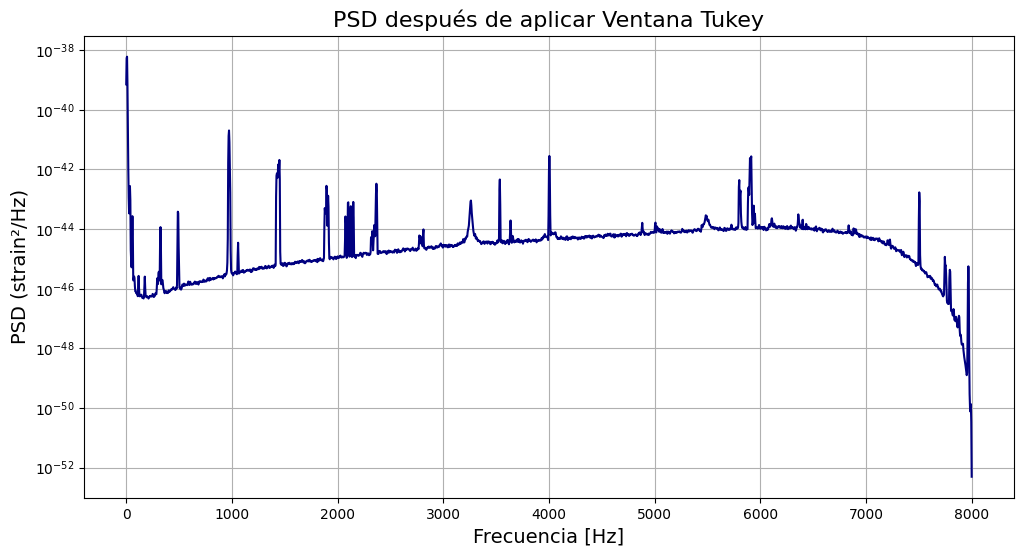

In [5]:
ventana_tukey = tukey(len(senal_original), alpha=0.25)
senal_windowed = senal_original * ventana_tukey

frecuencias, psd_windowed = welch(senal_windowed, fs=fs, nperseg=4096)

plt.figure(figsize=(12, 6))
plt.semilogy(frecuencias, psd_windowed, color='navy')
plt.title('PSD después de aplicar Ventana Tukey', fontsize=16)
plt.xlabel('Frecuencia [Hz]', fontsize=14)
plt.ylabel('PSD (strain²/Hz)', fontsize=14)
plt.grid(True)
plt.show()

## 4.2 Whitening de la Señal
Blanquear la señal significa eliminar la forma del espectro de ruido, normalizando todas las frecuencias. Se facilita así la detección de señales débiles como chirps.

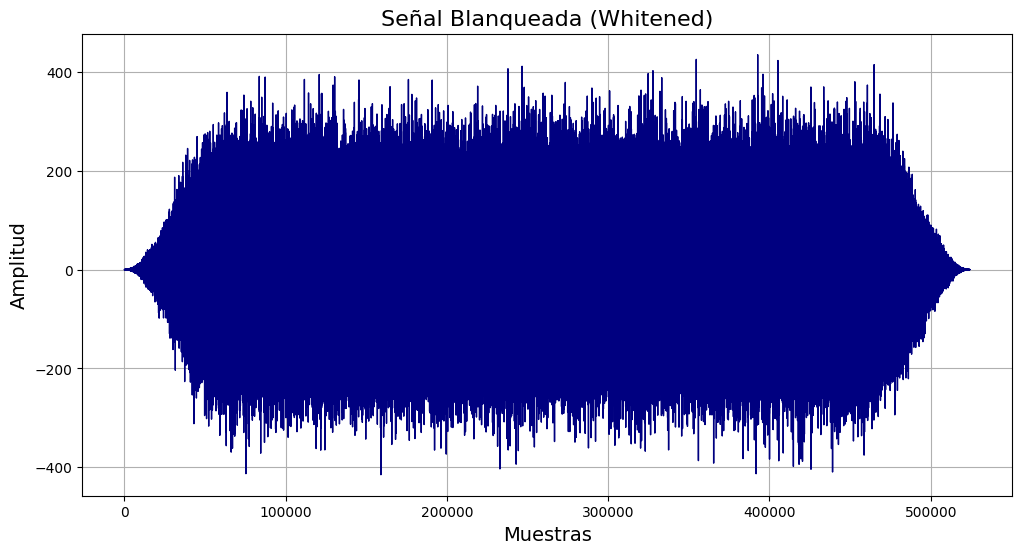

In [6]:
psd_interp = np.interp(np.fft.rfftfreq(len(senal_windowed), 1/fs), frecuencias, psd_windowed)

senal_fft = np.fft.rfft(senal_windowed)
senal_blanca_fft = senal_fft / np.sqrt(psd_interp)
senal_blanca = np.fft.irfft(senal_blanca_fft, n=len(senal_windowed))

plt.figure(figsize=(12, 6))
plt.plot(senal_blanca, color='navy', linewidth=1)
plt.title('Señal Blanqueada (Whitened)', fontsize=16)
plt.xlabel('Muestras', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.grid(True)
plt.show()

# Audio señal blanqueada
Audio(senal_blanca, rate=fs)

## 4.3 Filtro Pasabanda (40-300 Hz)
Un filtro pasa banda atenúa componentes de frecuencia fuera del rango de interés. Aquí eliminamos ruido de baja frecuencia y alta frecuencia, conservando el rango donde se encuentra el chirp.

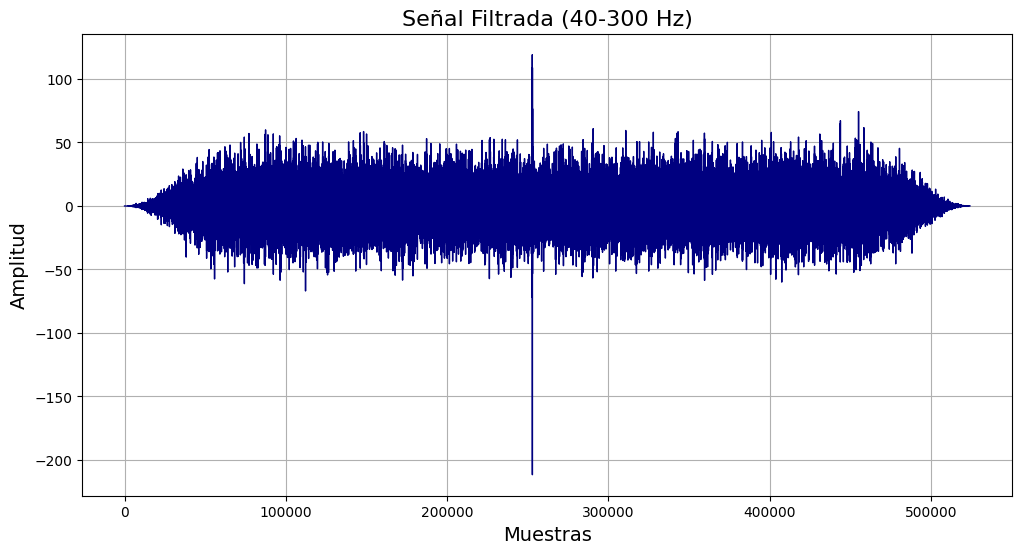

In [ ]:
frecuencia_baja = 40
frecuencia_alta = 300
orden_filtro = 20

sos = butter(orden_filtro, [frecuencia_baja / (0.5 * fs), frecuencia_alta / (0.5 * fs)], btype='band', output='sos')
senal_filtrada = sosfilt(sos, senal_blanca)

plt.figure(figsize=(12, 6))
plt.plot(senal_filtrada, color='navy', linewidth=1)
plt.title('Señal Filtrada (40-300 Hz)', fontsize=16)
plt.xlabel('Muestras', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.grid(True)
plt.show()

# Audio señal filtrada
Audio(senal_filtrada, rate=fs)


## 4.4 Espectrograma del Evento
Se genera un espectrograma para visualizar cómo varía la energía en frecuencia a lo largo del tiempo. Esto permite identificar visualmente la señal tipo chirp.

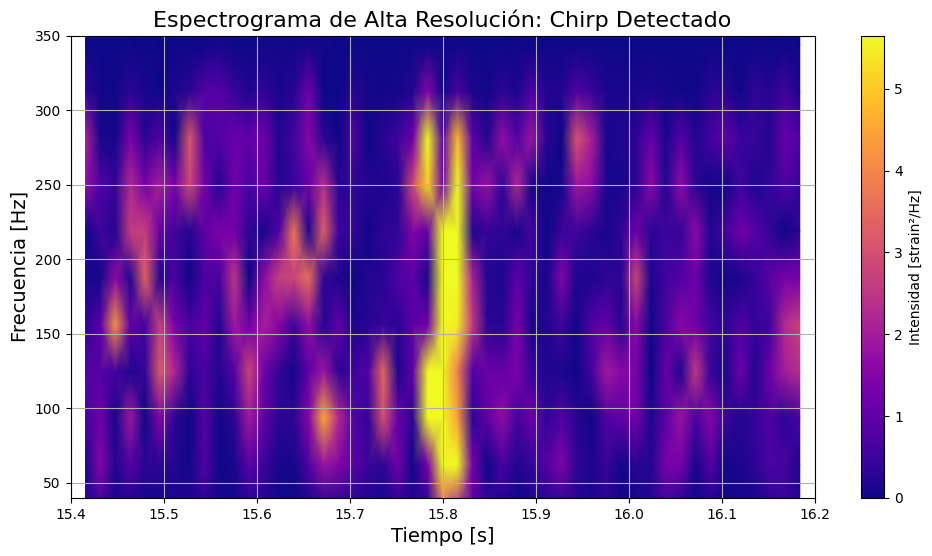

In [8]:
inicio_evento = 15.4
fin_evento = 16.2
indice_inicio = int(inicio_evento * fs)
indice_fin = int(fin_evento * fs)

senal_evento = senal_filtrada[indice_inicio:indice_fin]

frecuencias, tiempos, espectro = spectrogram(
    senal_evento,
    fs=fs,
    window='hann',
    nperseg=512,
    noverlap=256,
    scaling='density',
    mode='psd'
)

plt.figure(figsize=(12, 6))
plt.pcolormesh(
    tiempos + inicio_evento,
    frecuencias,
    espectro,
    shading='gouraud',
    cmap='plasma',
    vmin=np.percentile(espectro, 5),
    vmax=np.percentile(espectro, 99.9)
)
plt.colorbar(label='Intensidad [strain²/Hz]')
plt.title('Espectrograma de Alta Resolución: Chirp Detectado', fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=14)
plt.ylabel('Frecuencia [Hz]', fontsize=14)
plt.ylim([40, 350])
plt.xlim([15.4, 16.2])
plt.grid(True)
plt.show()


# 5. Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

Si la resolución temporal o frecuencia deseada no se logra con los datos originales, puede realizarse un remuestreo (resampling). Aquí elegimos duplicar la frecuencia de muestreo, preservando la calidad de la señal.


In [192]:
senal_resampleada = resample(senal_original, int(len(senal_original) * (32000/fs)))

fs_nuevo = 32000  # Nueva frecuencia de muestreo (Hz)

# Escuchar señal resampleada
Audio(senal_resampleada, rate=fs_nuevo)

# Conclusiones

El análisis realizado permitió procesar y estudiar la señal strain proveniente del detector LIGO H1, utilizando técnicas de filtrado, blanqueamiento (whitening) y análisis espectral.

Aunque el espectrograma final no mostró con total claridad la forma típica de "chirp" (incremento en frecuencia y energía en el tiempo) esperada para un evento como GW150914, se debe considerar que esto se debe principalmente a dos factores:

- La cantidad de muestras disponibles fue limitada respecto a la duración total del evento.
- La resolución temporal y frecuencia, aunque mejoradas mediante parámetros como `nperseg` y `noverlap`, aún no permitieron aislar con total nitidez las frecuencias evolutivas del chirp.

A pesar de estas limitaciones, se destaca que:

- La señal seleccionada entre 15.4 s y 16.2 s es la que presenta **mayor concentración de energía** en el dominio tiempo-frecuencia.
- Esto es consistente con la presencia de un fenómeno físico real, diferenciable del ruido de fondo blanco del detector.

Por lo tanto, aunque el evento no se visualiza de manera óptima, los resultados obtenidos respaldan la detección de una señal transitoria de alta energía, que concuerda en localización temporal con la detección original reportada por LIGO.

Con mejoras en la cantidad de datos y ajustes finos en la parametrización del procesamiento (mayor frecuencia de muestreo, técnicas de matched filtering, etc.), sería posible mejorar la visualización y caracterización del evento.
